In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, accuracy_score

from xgboost import XGBClassifier

In [59]:
df = pd.read_csv('D:\TEMP\Course/my_phone.csv', index_col=0)
display(df)
display(df.describe())

,battery_power,bluetooth,weight,memory,n_cores,ram,dual_sim,wifi,pixel_height,pixel_width,price_range
0,842,NO,188,7,2.0,2549,0,1,20,756,1.0
1,1021,YES,136,53,3.0,2631,1,0,905,1988,2.0
2,563,YES,145,41,5.0,2603,1,0,1263,1716,2.0
3,615,YES,131,10,6.0,2769,0,0,1216,1786,2.0
4,1821,YES,141,44,2.0,1411,0,0,1208,1212,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4015,747,NO,131,10,2.0,103,1,0,767,1024,1.0
4016,766,NO,104,12,3.0,355,0,0,428,456,1.0
4017,839,NO,112,9,1.0,408,1,1,1088,255,1.0
4018,809,NO,123,7,2.0,112,1,0,365,1173,1.0


,battery_power,weight,memory,n_cores,ram,wifi,pixel_height,pixel_width,price_range
count,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,3020.000000
mean,1127.392289,139.426617,27.362438,3.963930,1715.922637,0.501990,672.843532,1116.360945,1.331126
std,425.790696,33.675572,18.112879,2.220142,1184.300498,0.500058,404.404351,459.694423,0.940227
min,500.000000,80.000000,2.000000,1.000000,6.000000,0.000000,0.000000,240.000000,0.000000
25%,780.750000,111.000000,12.000000,2.000000,652.000000,0.000000,364.750000,739.000000,1.000000
50%,983.000000,139.000000,22.000000,4.000000,1489.500000,1.000000,635.000000,1065.500000,1.000000
75%,1489.000000,168.000000,43.000000,6.000000,2746.000000,1.000000,951.000000,1492.250000,2.000000
max,1999.000000,200.000000,64.000000,8.000000,3998.000000,1.000000,1960.000000,1998.000000,3.000000


In [60]:
df.nunique()

battery_power    1295
bluetooth           2
weight            121
memory             63
n_cores             9
ram              2446
dual_sim            3
wifi                2
pixel_height     1417
pixel_width      1543
price_range         4
dtype: int64

## 1. Categorical columns
Columns with low number of unique values should be categorical (bluetooth, n_cores, dual_sim, wifi, price_range).
n_cores and price_range should be ordinal encoded, because they have certain direction of value. Other categorical columns can be either one-hot-encoded or ordinal encoded due to their binary nature. We will ordinal encode them too.

In [61]:
df.dual_sim.value_counts()

1     2039
0     1937
NO      44
Name: dual_sim, dtype: int64

## 2. dual_sim contains incorrectly formated values (1 error)
We will change 'NO' values into 0.

In [62]:
# correct dual_sim
df.dual_sim = df.dual_sim.map(lambda x: 0 if x == 'NO' else x)

In [63]:
df.dtypes

battery_power      int64
bluetooth         object
weight             int64
memory             int64
n_cores          float64
ram                int64
dual_sim          object
wifi               int64
pixel_height       int64
pixel_width        int64
price_range      float64
dtype: object

## 3. Incorrect data types (Error 2)
Categorical n_cores and price_range should be discrete (either int64 or object)

In [64]:
# correct dual_sim and bluetooth
df.bluetooth = df.bluetooth.map(lambda x: 1 if x =='YES' else 0).astype('int64')
df.dual_sim = df.dual_sim.astype('int64')

In [65]:
df.isnull().sum()

battery_power       0
bluetooth           0
weight              0
memory              0
n_cores             0
ram                 0
dual_sim            0
wifi                0
pixel_height        0
pixel_width         0
price_range      1000
dtype: int64

## 4. No empty values

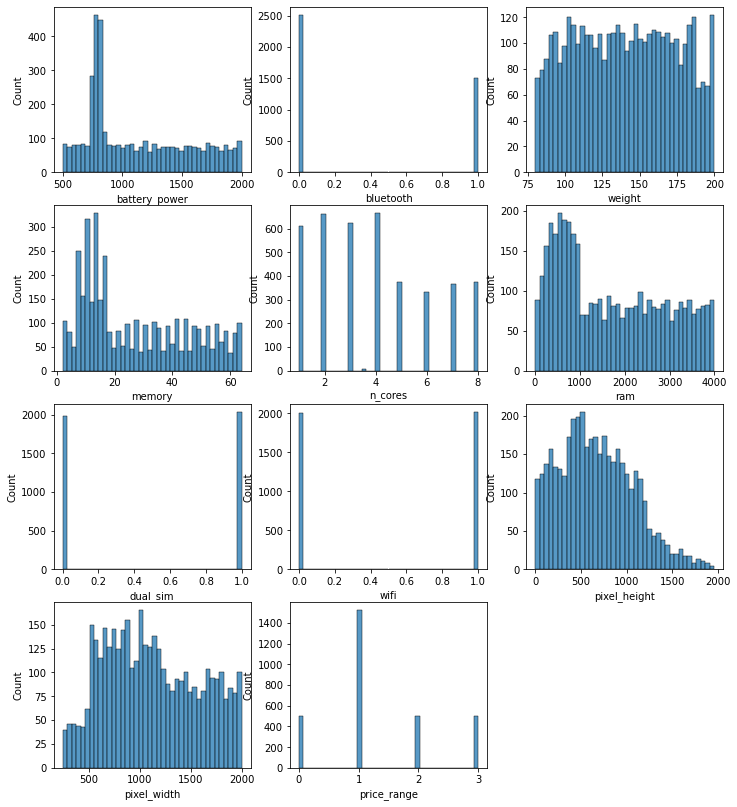

In [66]:
#plt.subplots(3,3)
i=0
plt.figure(figsize=(12,14))
for col in df.select_dtypes('number').columns:
    i+=1
    plt.subplot(4,3,i)
    #plt.title(col)
    sns.histplot(x=df[col], bins=40)
plt.show()

In [67]:
df.n_cores.value_counts()

4.0    665
2.0    662
3.0    622
1.0    613
8.0    377
5.0    376
7.0    366
6.0    331
3.5      8
Name: n_cores, dtype: int64

## 5. n_cores contains incorrectly formatted values (Error 3)
We will change 3.5 cores into 4 cores because it is between 3 and 4 cores but 4 cores value is more probable. 

In [68]:
# n_cores correction
df.n_cores = df.n_cores.map(lambda x: x if x != 3.5 else 4)

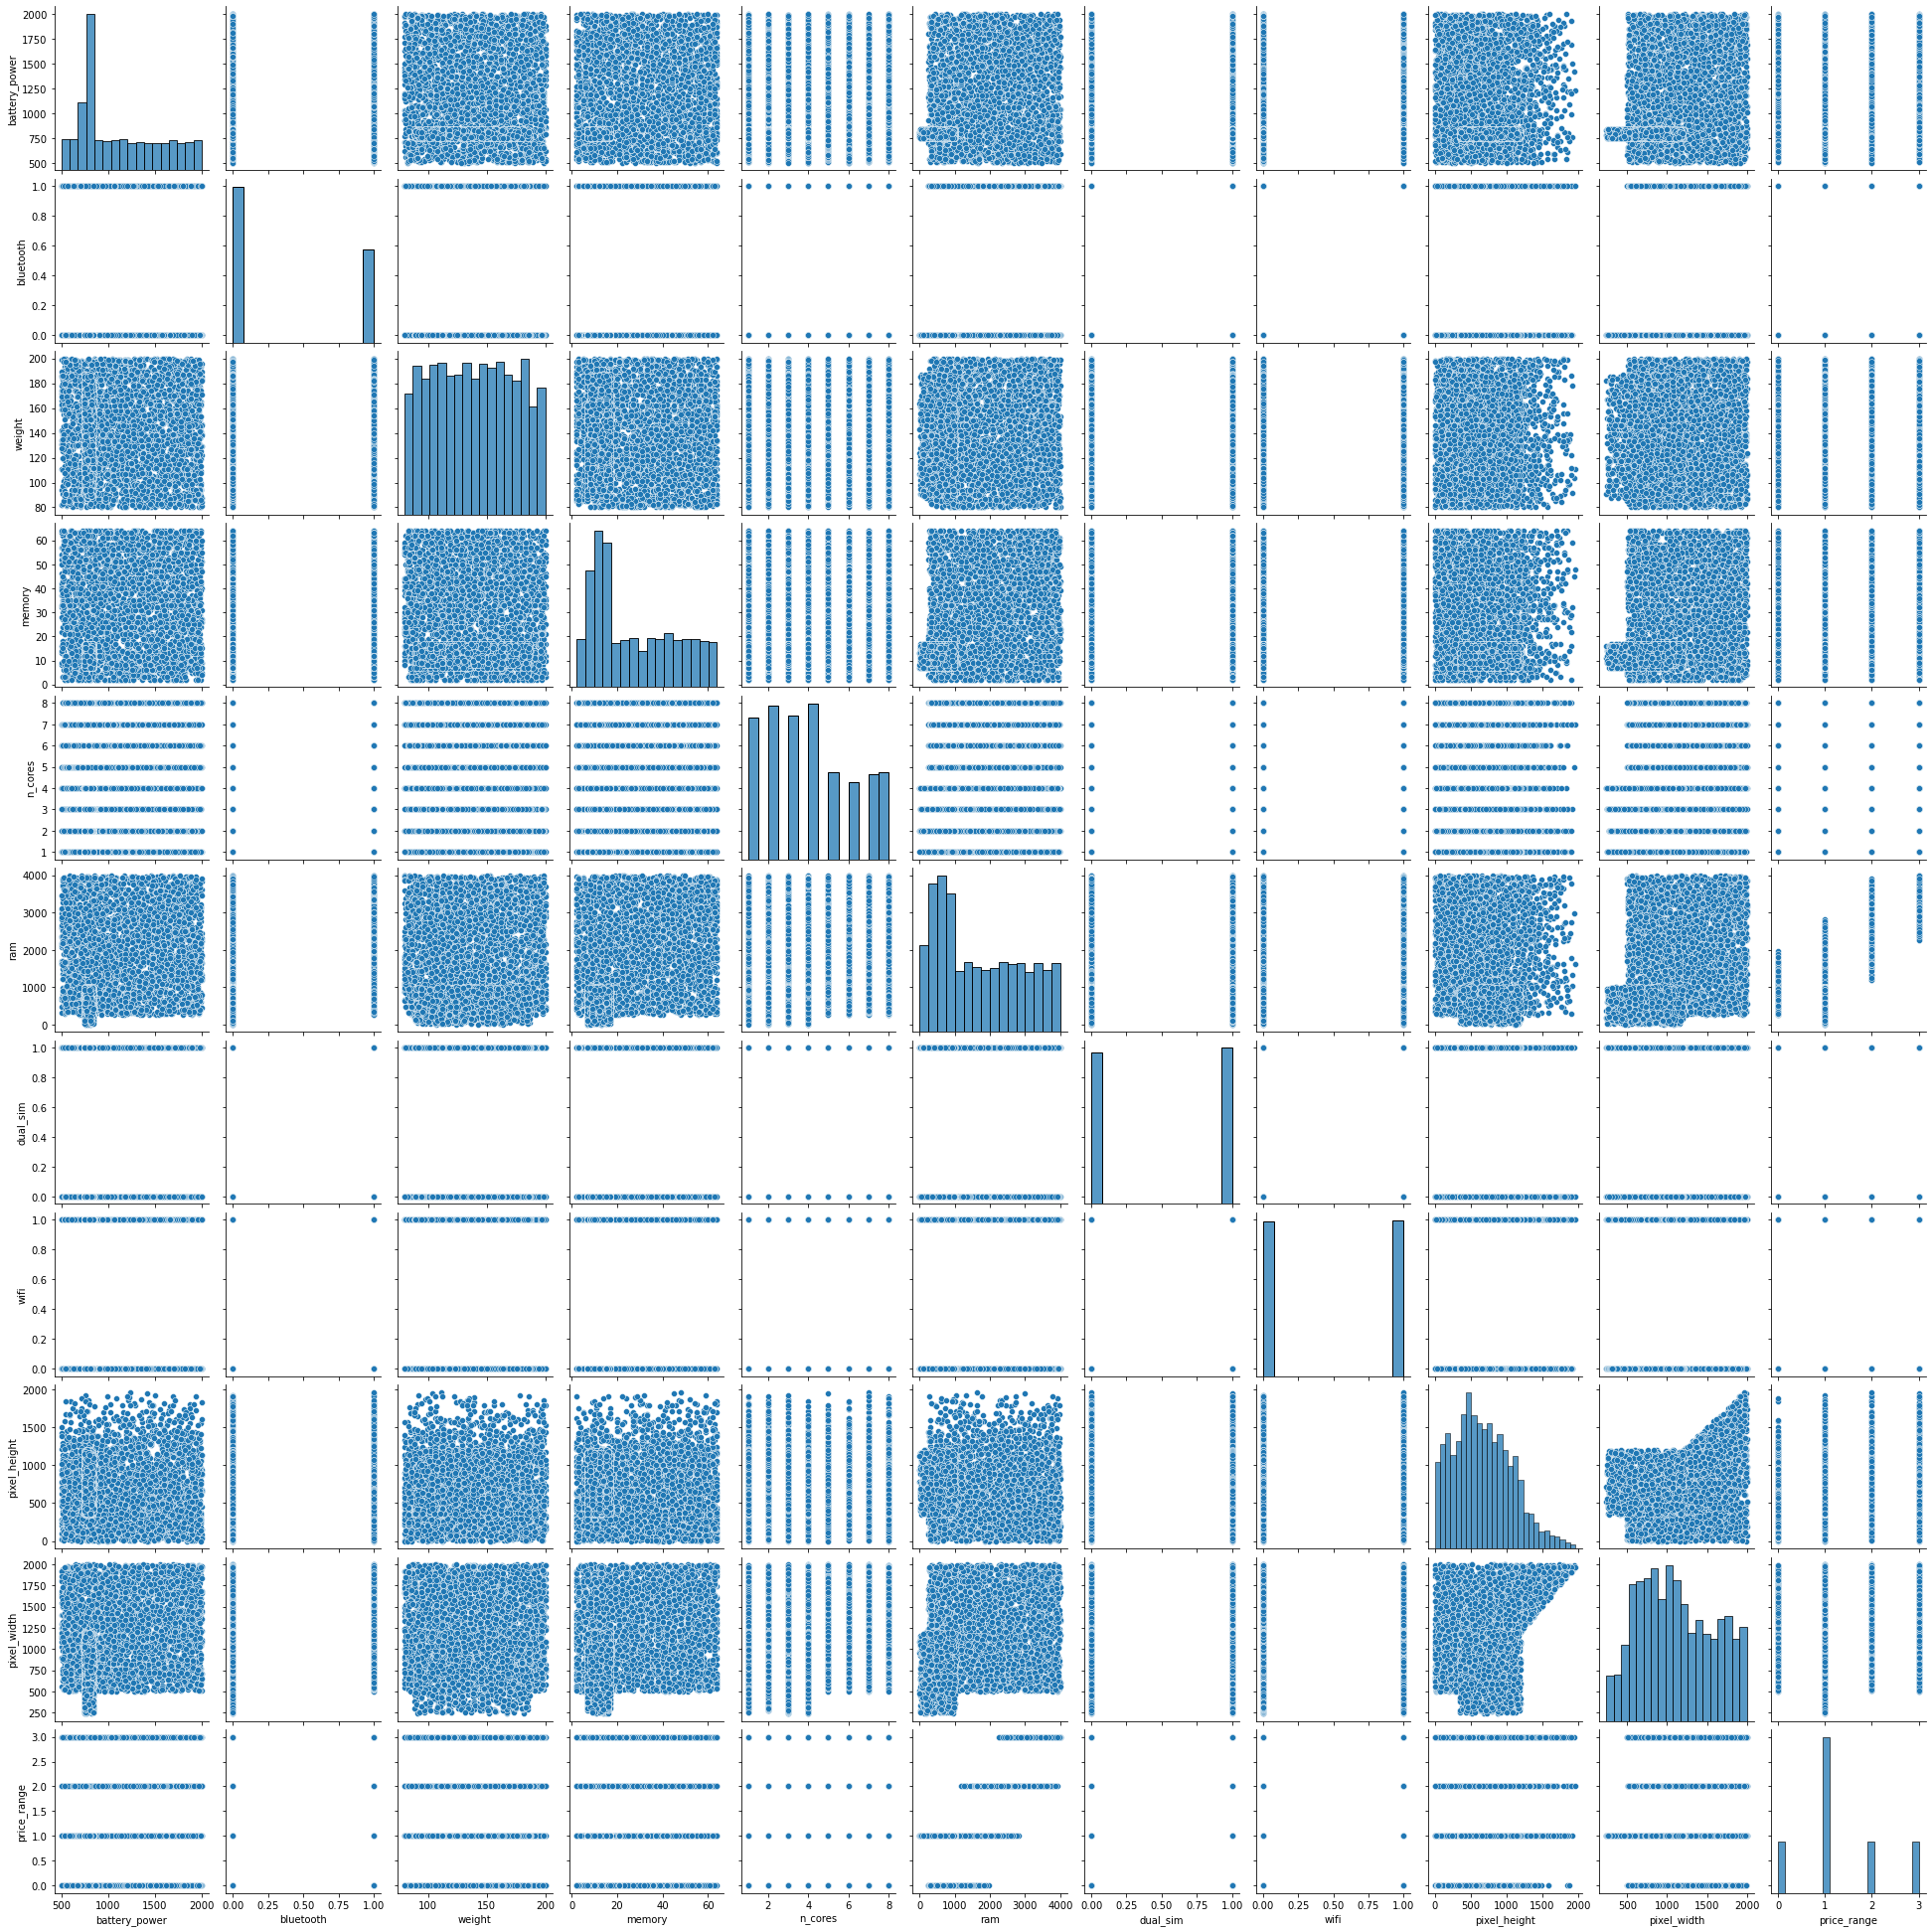

In [69]:
sns.pairplot(df)

## 6. Mixed distributions (Error 4)
battery_power, memory, ram, pixel_width and pixel_height contains several uniform distribution. + incorrect data

In [70]:
df.pixel_height = df.pixel_height.map(lambda x: 500 if x < 500 else x)
df.pixel_width = df.pixel_width.map(lambda x: 500 if x < 500 else x)
df.drop(df[df['ram'] < 100].index, inplace = True)

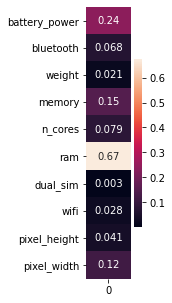

In [71]:
# split data frame
y = df.price_range
X = df.drop('price_range', axis=1)
X_test = X.loc[y.isnull()]
X = X.drop(X_test.index) 
y = y.drop(X_test.index)

mi_scores = mutual_info_classif(X, y, discrete_features='auto')

plt.figure(figsize=(1,5))
sns.heatmap(pd.DataFrame(mi_scores, index=X.columns), annot=True)
plt.show()

## Mutual information
Mutual information indicates that most data in common with target value is contained in ram, battery_power, memory and pixel_width

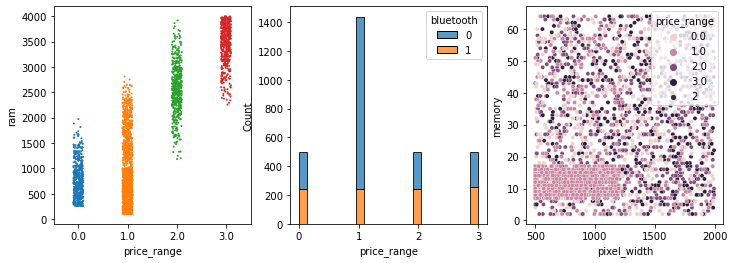

In [72]:
plt.figure(figsize=(12,4))
plt.subplot(131)
sns.stripplot(x=y, y=X.ram, size=2)
plt.subplot(132)
sns.histplot(x=y, hue=X.bluetooth, multiple='stack')
plt.subplot(133)
sns.scatterplot(x=X.pixel_width, y=X.memory, hue=y, size=2)
plt.show()

## Linear regression

In [73]:
def test_linear():
    model = LinearRegression()
    return -1 * cross_val_score(model, X[features], y, cv=5, scoring='neg_mean_absolute_error').mean()

def test_logistic():
    model = LogisticRegression(max_iter=500, random_state=1)
    return cross_val_score(model, X[features], y, cv=5, scoring='accuracy').mean()

def test_kmeans():
    model = KMeans(n_clusters=4)
    return model.fit(X[features])

In [74]:
features = ['ram', 'bluetooth', 'memory', 'pixel_width']

In [75]:
linear_score = test_linear()
logistic_accuracy = test_logistic()
clasters = test_kmeans()

C:\Users\Genia\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\Genia\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

In [76]:
print(f'Linear regression MAE: {linear_score:.2}')
print(f'Logistic regression accuracy: {100*logistic_accuracy:.4}%')

Linear regression MAE: 0.47
Logistic regression accuracy: 69.61%


Predictions:


C:\Users\Genia\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


,0
2000,3.0
2001,3.0
2002,2.0
2003,3.0
2004,1.0
...,...
2995,2.0
2996,1.0
2997,1.0
2998,2.0


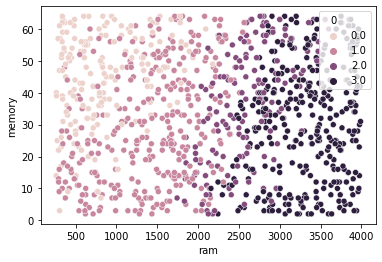

In [77]:
# train logistic regression on all available data
model = LogisticRegression(max_iter=500, random_state=1).fit(X[features], y)
print('Predictions:')
logistic_predictions = pd.DataFrame(model.predict(X_test[features]), index=X_test.index)
display(logistic_predictions)

sns.scatterplot(x=X_test['ram'], y=X_test['memory'], hue=logistic_predictions[0])
plt.show()

,0
0,3
1,3
2,3
3,3
4,2
...,...
4015,0
4016,0
4017,0
4018,0


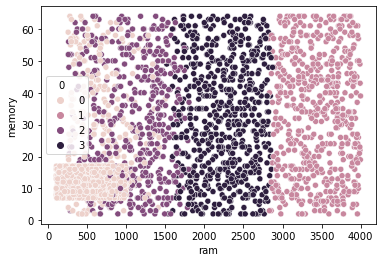

C:\Users\Genia\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


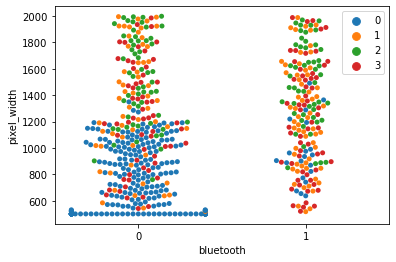

In [78]:
# clustering on train data
train_clusters = pd.DataFrame(clasters.predict(X[features]), index=X.index)
display(train_clusters)

sns.scatterplot(x=X['ram'], y=X['memory'], hue=train_clusters[0])
plt.show()
temp_df = X.sample(frac=0.2)
sns.swarmplot(x=temp_df['bluetooth'], y=temp_df['pixel_width'], hue=train_clusters[0][temp_df.index])
plt.show()

,0
2000,1
2001,1
2002,3
2003,1
2004,3
...,...
2995,3
2996,3
2997,0
2998,3


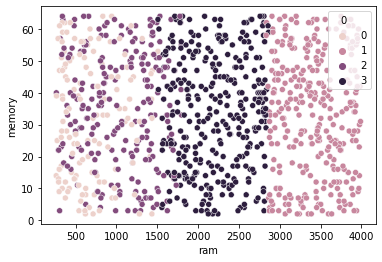

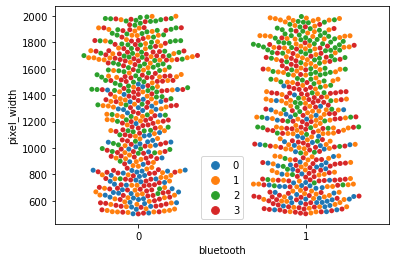

In [79]:
# clustering on unseen data
test_clusters = pd.DataFrame(clasters.predict(X_test[features]), index=X_test.index)
display(test_clusters)

sns.scatterplot(x=X_test['ram'], y=X_test['memory'], hue=test_clusters[0])
plt.show()
sns.swarmplot(x=X_test['bluetooth'], y=X_test['pixel_width'], hue=test_clusters[0])
plt.show()

## XGBoost 

In [80]:
xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=6, random_state=0)
X_train, X_valid,  y_train, y_valid = train_test_split(X, y, train_size=0.7)
score = xgb_model.fit(X_train[features], y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid[features], y_valid)],
             verbose=False)
print(accuracy_score(xgb_model.predict(X_valid[features]), y_valid))

C:\Users\Genia\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


0.8503401360544217


,0
2000,3
2001,3
2002,2
2003,3
2004,1
...,...
2995,1
2996,1
2997,1
2998,2


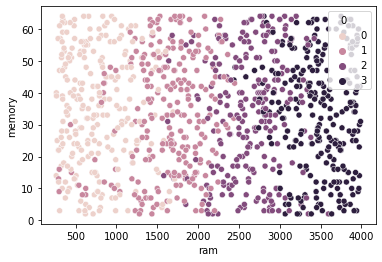

In [81]:
xgb_predict = pd.DataFrame(xgb_model.predict(X_test[features]), index=X_test.index)
display(xgb_predict)

sns.scatterplot(x=X_test['ram'], y=X_test['memory'], hue=xgb_predict[0])
plt.show()